<a href="https://colab.research.google.com/github/restartus/covid-projection/blob/rich-demo/Restart_model_readme_2020_07_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

_Proprietary and Confidential. Do not distribute without permission._

---

# Restart Partners   - Sample Memo

---
_To:_ Jun Amora (Mayors Office, City of New York)  
_From:_ Bharat Shyam, Rich Tong (Restart)  
_Re:_ Analysis for NYC PPE needs  
_Date:_ 20 May 2020  

--- 

New York City needs a 90-day stockpile for the heathcare workers, first responders and congregate care facilities is really important, but coming up with an estimate for this is difficult given the variability of the infection and the uncertainty in the degree of economic recovery and social mobility. Therefore, we are providing another resource model to augment yours that shows that our figures are within 30%-50% of your bottoms estimate. Given that we are happy to:

- _Refine healthcare estimates_. All models are heavily dependent on estimates of population involved and usage data. 
- _Non-healthcare estimates_. For instance, this model does project needs outside of the healthcare area such as small business, vertical industries and vulnerable populations.
- _Long-term modeling_. We are extending the model to include test equipment, disinfectant wipes and liquid disinfectants, so happy to add things that you need. Also we will be integrating epi and economic models too and would love to partner with you on that.

Given the uncertainties involved, this might help you make the right estimates. What follows next are:

1. Disclaimer. This is not a definitive estimate. You should use other sources and information to make your decisions.
2. Data Sources. We have included the model source data, how the model is constructed and then results. Feel free to use this data and modify as appropriate, but it serves as documentation for all the assumptions made.
3. Model. The way the calculation is done with assumptions and resulting projections
4. Outputs. The conclusions we can draw from the projection.

## Disclaimer
It must be noted that the Restart Partners ("Restart") Equipment Model (the "Model") is made available for public use free of charge. Determining equipment needs for each jurisdiction, entity or other party (each a "User") is a complex and multifaceted decision process. Restart does not does not have the authority or ability to assign empirical risks levels nor make definitive use decisions for any User. Rather, the Model provides one approach to making recommendations that can help Users make decisions about their potential equipment uses by allowing them to calculate their potential requirements. Users are strongly encouraged to consider other sources of information and expressly disclaim any cause of action they may have against Restart arising from or relating to the Model or its analysis. Implementing the equipment levels projected by the Model will not eliminate the risk of COID-19 cases being linked to activites in an economy or workplace. In this context, it is important to note that this equipment alone will not eliminate the risk of infection. All Users should remain informed about and abide by any decisions made by local public health and government authorities regarding specific mitigation efforts, including equipment in the model, as the situation is dynamic.


# Model Data for New York use Washington Consumption

Because we do not have New York City specific data, we used various open data sources to fill in the five major assumptions in the model:

1. Usage by Population. This cuts the item usage per person per day. This right now is a series of levels. So we have four levels for civilians and then two levels for healthcare workers.
2. Usage per Patient. This is the way Epidemiological models work. That is, given a number of patients, calculate how much they will need. The model currently uses the [WHO Surge Essential Supplies Forecasting Tool v1.2](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/covid-19-critical-items) and estimates the entire US population use with 1,000 cases and fast transmission and slow response. So this is a very pessimistic scenario. This makes sense when calculating the surge estimates.

# The Component architecture of the code classes

The architecture of system models the three things happening in the real world which are the relationships between a population at the center. Here are the basic components of the v2 model and the graphical representation is below:

1. Population. This contains all the data on the people under study. This includes the mapping of large population classes into a smaller set of essentiality levels for display 
2. Resource. Contains all the equipment needed to fight the pandemic and models how they are supplied including the inventory and stockpile levels.
3. Disease. Contains all the disease modeling
4. Economy. Contains the econometric and economic activity modeling
5. Behavioral. How will people behave drives disease and recovery

digraph "Class Model" {
	node [shape=box]
	subgraph Pop_class {
		style=filled
		P [label=Population]
	}
	C [label=Consumption]
	P -> C [label=Counts]
	A [label=Activity]
	P -> A [label=Counts]
	A -> P [label="%Normal"]
	D [label="Disease (Epidemiological)"]
	D -> P [label=Recovered]
	P -> D [label=Cases]
	E [label=Economics]
	E -> P [label="GDP, Employment"]
	P -> E [label=Cost]
	B [label=Behavior]
	P -> B [label="Motivation, Ability, Prompt"]
	B -> P [label=Activity]
	subgraph Res {
		R [label=Resource]
		R -> P [label=Supply]
		C -> R [label="Burn Rates"]
		I [label=Inventory]
		R -> I [label=Fill]
		I -> R [label=Use]
		S [label=Supply]
		R -> S [label="Sales Order"]
		S -> R [label=Fulfillment]
	}
}


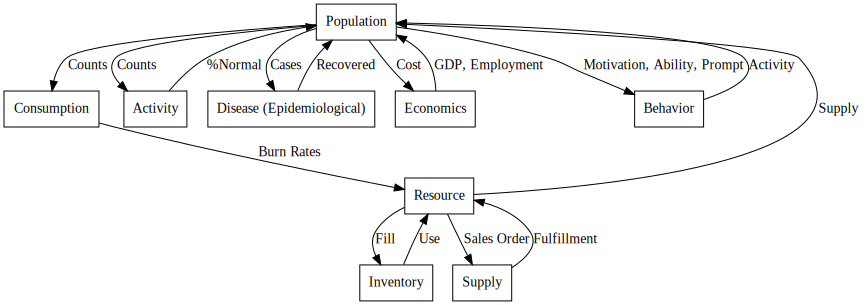

In [8]:
# https://h1ros.github.io/posts/introduction-to-graphviz-in-jupyter-notebook/
# https://www.graphviz.org/pdf/dotguide.pdf for directed graphs manual
# https://www.graphviz.org/pdf/neatoguide.pdf for undirected manual
# https://graphviz.readthedocs.io/en/stable/manual.html
from graphviz import Digraph, Graph
dot = Digraph('Class Model', node_attr={'shape': 'box'})
neato = Graph(engine='neato')

# Population superclass using cluster as a special name
# Note that name must be a named parameter
# https://graphviz.readthedocs.io/en/stable/examples.html#cluster-py
with dot.subgraph(name='Pop_class') as c:
  c.attr(style='filled')
  c.node('P', 'Population')

dot.node('C', 'Consumption')
dot.edge('P', 'C', 'Counts')

dot.node('A', 'Activity')
dot.edge('P', 'A', 'Counts')
dot.edge('A', 'P', '%Normal')

dot.node('D', 'Disease (Epidemiological)')
dot.edge('D', 'P', 'Recovered')
dot.edge('P', 'D', 'Cases')

dot.node('E', 'Economics')
dot.edge('E', 'P', 'GDP, Employment')
dot.edge('P', 'E', 'Cost')

dot.node('B', 'Behavior')
dot.edge('P', 'B', 'Motivation, Ability, Prompt')
dot.edge('B', 'P', 'Activity')

with dot.subgraph(name="Res") as c:
  c.node('R', 'Resource')
  c.edge('R', 'P', 'Supply')
  c.edge('C', 'R', 'Burn Rates' )
  c.node('I', 'Inventory')
  c.edge('R', 'I', 'Fill')
  c.edge('I', 'R', 'Use')
  c.node('S', 'Supply')
  c.edge('R', 'S', 'Sales Order')
  c.edge('S', 'R', 'Fulfillment')

# https://pypi.org/project/graphviz/
# print the actual dot file
print(dot.source)

# now render in the notebook
display(dot)


# A note on notation
We have two sets of notation:

- Formulaic notation using Latex that is suitable for math and proofs. It more concise, but derivable from and convertable to the long code names.
- Notation for coding in Python. In this we are using some coding conventions as the terms can be confusing. We use snake_case for local variable and suffix each matrix or array with their dimensions. We use unique letters for various dimensions. For instance, we have p populations and n resources, so a matrix which is p rows and n columns would look like `data_pn_df` and then the last suffix is the data type

## Einstein Summation
Besides matrix multiplication and element-wise multiplication, we also make sure of [Einstein Summation](https://mathworld.wolfram.com/EinsteinSummation.html) popularized by Einstein's use in proving his theories, the notation allows axis summation, so that each index indicates what is iterated over and the left hand indicates what is summed or squashed

$$
P^C_{pn} = P_{pn}\,PE^T_{tnp}
$$

This is exactly equivalent to 

    PT_tpn = np.einsum("pn,tnp=pn",P_pn_df, T_tnp_df)






# Classes of the Model v2.x

The general scheme is that there is a class Model which gets instantiated with all the appropriate labels. This provides the implicit dimensions of the model.

## Model $M$ or `model`
This is the core framework. It holds the dimensions and pointers to all the module component instances. It's main use is to "dimension" the problem so that the other subclasses know the size of the problem. It also holds points to the entire "graph" of objects (similar to a Keras object in machine learning. So the process is to add "layers" or model elements, then run the model as needed with a "solver" that is used for specific purposes and later for optimization of an objective function.

Each major module can be subclassed from this and your can replace it. The current list of modules are and in the notation, the class name is the major part of the variable

## Population as $P$ or `pop` with index `p`

This holds the population and details about it. It's main output are two fold with a set of variables including:

- Attributes $P^A_{pd}$ or `attr_pd_df` indexed by `d`. This includes in the first column for the number of people. 
- Protection Mappings $P^M_{pm}$ or `protection_pm_df` indexed by `m`. These are the levels for various works
- Protection Demand $P^D_{mn}$ or `prot_demand_mn_df` which maps the `m` protection map to the actual consumption for each `n` resource
- Population Level $P^L_{pl}$ or `level_pl_df` which maps a very large set of p population to a displayable set of `l` levels like essential and non-essential workers.

## Resource $R$ or `Resource` with index `n`
The resources needed, it takes demand from Population and returns to the population what can actualy be supplied.
  - Attribute $R^A_{na}$ `attr_na_df` index with `a`
  - Cost $R^C_{ln}$ `cost_ln_df` index with `ln` matrix which allows different 
  - Initial inventory $R^I_{ln}$ `initial_inventory_ln_df` for initial store
  - Economic order quantity $R^E_{ln}$ `eoc_ln_df` for economic order quantity
  - Safety stock $R^S_{ln}$ or `safety_stock_ln_df` for minimum inventory

##Economy $E$ or `econ` for v3
This is a model of the economy that takes in the Population and the degree of economic activity and returns the GDP and employment and other measures of work

##Disease $D$ or `disease` for v3
This models the progression of the disease and takes in the population and social mobility and it returns the number of patients, deaths and recovered patients.



# Follow-on versions from v2 to v2.x

The next steps are a little complicated, but we are converting the entire model into a series of vectorized operations. This documents:

## v2. Duplicate the Excel Surge

This duplicates the current surge model that is run by the Excel sheets as of v1.4.7. This is meant as a check of formulas and to ensure have duplicated the model.


## v2.1 Add patients, more tests and tempos

This includes calculations for adding patients counts and test tempos. This assumes that testing is either brought in as a separate module and the patients as well as a function of either SIR data or with some test method such as used by BMGF spreadsheets or WHO. It also adds burn rates by more than just daily per capita.

## v2.2. Add ranges of costs

In parenthesis are the notes for integrating the new features of v2.x. This includes a time series as the main features

## v2.3 Add Time series

So we do more than the surge model

## v2.4 Think aboiut doing distributions rather than just ranges

Would have a range of units increasing the dimensionality again. At this point, we might move to a mean with a sigma instead of many different parameters. This would mean we would have to do distribution math which asusming we have normal distributions is possible. For instance [normal distribution math](https://math.stackexchange.com/questions/2314763/variance-operations-on-the-normal-distribution) shows in [Latex](https://towardsdatascience.com/write-markdown-latex-in-the-jupyter-notebook-10985edb91fd)

$$
X = N(\mu, \sigma^2)\\
Y = N(\upsilon, \tau^2)\\
aX + bY = N(a\mu + b\upsilon, a^2\sigma^2 +b^2\tau^2)
$$

And I'm pretty sure this distribution math is a numpy function somewhere :-). However, the [product of two normal distributions](http://pldml.icm.edu.pl/pldml/element/bwmeta1.element.bwnjournal-article-doi-10_7151_dmps_1146/c/dmps.1146.pdf) is not normal, it is a Bessel function so it might be better just to use ranges which are a little easier to manage. 





# Additional extensions to move to time

## Model Class

v2.3. An idea is that when you change this, how does it dynamically recalculate

## Resource $R^A$ `attributes Notes

This in the simplest form is just a vector of 1s with the labels being the materials.

   Resource[n, 1] = np.ones((n, 1))

We can handle any arbitrary vector of items, just change the list. Longer term, we will have our own GUID system, but right no rely on unique text strings

### A note on handling conservation by amortizing specific items.

In the v1.x models, we had a series of calculations indicating which items were reusable and which weren't. With an unlimited number of columns, it is much eaiser to just have dedicated items for:

- Cloth masks
- Disinfectable N95 respirators

Then if an article lasts n days, set their tempo of use to 1/n, so a cloth mask that can be used for 10 days for disposal would be 0.1.

This does not quite model the spike and flow, but is a decent approximation for now over many days.

## Extending Physical facts about resources, `Resource.attr[d, n]`, $R_{dn}$ for v2.2


We need to know some physical characteristics about resources. This could also come from Supply but will likely be more static. Some of the key ones are the volume and count

    Resource_dn = [ units, square footage, weight, volume 

The other variables for the resource are physical characteristics like the volume of the package.



## `Population.attr_pa` or $P_{pd}$ in v2.1 and higher
v2.1 adds more population details d which can be for instance run rates for EMTs, number of potential cases in a class (althought this might move to the disease model) so this become `population_pd` $P(p,d)$)





# Population Demand $P^D_{dln}$ v2.
Demand adds a detail level for multiple tempos `demand_res_dln[d, l, n]`, $P^OR_{dln}$
v2.1 will add a population detail level so you can have tempos of things other than per capita, for instance, it could be per run or per COVID patient in the population and then it becomes `Usage_to_res_dln $C[d, n, l]` where d are the population Details.

# Model Class: Each population's demand for resources per capita: `Population.resource_pn`, $P^D_{pn}$
This is the first derived figure taking in the above variables

So with this, you can see that with a single operation you can get to the actual equipment levels require per person per day for a given population. Note that there is new Python 3.5 syntax for [matrix multiply](https://docs.python.org/3/whatsnew/3.5.html#whatsnew-pep-465)

$P^D_{pn} = P^M_{pm} x $P^{PD}_{mn}$

In Python Numpy speak, we are doing a matrix [multiply](https://www.tutorialexample.com/understand-numpy-np-multiply-np-dot-and-operation-a-beginner-guide-numpy-tutorial/)

    # Now you can see the value of the suffix
    # It is a quick check because for a matrix multiply to work
    # you need the column of the first to match the row of the second
    # Note how with a matrix, both the name `use` and the subscript
    # `l` must match for this to work properly
    population.demand_pn_df = protection_pm_df @ prot_demand_mn_df

Note that this is still in "per capita terms" that is we are getting usage per person and have not gotten to the total population yet.

## v2.1 Extend to multiple burn rates $P^D_{dln}$ or `demand_dpn`
In v2.1,  When this is extended with different burn rates this becomes a multi-dimensional array.

The key concept is that P^M @ P^PD is really an assumption about the per capita rate is 1, so with d=1, it simplifies to just $P^L_{mn}$, but in v2.1, you have for each detail as different run rate so the usage matrix has a new dimension UR[d, l, n] or for each detail, there is a different consumption level l for every resource item n.

Assuming we have to do the PU[p, l] across then we need to broadcast this multiply across UR[1, p, n], UR[2, p, n],... And then sum it which is easy to do with an einsum:

    # v2.1 with details
    $PU x UR = PU[p, l] x UR[d, l, n] = P_R[d, p, n]$
    # In python this is easiest to do as an einsum
    population.demand_dpn = np.einsum("pl,dln=dln", protection_pl_df, demand_dln)

With UR, you can create specific levels like EMT for instance with different runs and you can have some based on number of EMTs, another d could be number of runs per day handled or number of COVID-19 patients or number of suspected cases. This gives you great flexibility in assignment of run rates. You don't have to convert everything to per capita numbers.

Most of these matrices will be very sparse, but it removes so much specific logiv and replaces it with very fast matrix multiplies.



# Moving Beyond Surge in v2: Adding Disease $D$, Behavioral $B$ and Economics $E#

There are four major goals for V2.x:

Time series forecast based of what's needed so that all matrices now have a time dimension so you can see things change with time.

Explicit utilization models beyond per capita the two major ones are
    - per "run or 911 call" for things that are incident based. This means that every population is going to have an activity matrix in addition to the population matrix
    - per COVID PUD (Patient Under investigation) mainly for testing tempos so there will be a matrix of how many patients there are in a given population

The time series particularly for activity is based on social mobility model that is handled off this model, but comes in as a matrix $B_{tp}$ which is how each social mobility population changes for time indexed on 100% at Feb 7.

Time series that is the disease progression from SIR or other Epi model which modeled as $D_{tp}$ so you can look at various populations with differential infection rates.

## The first step extending with an time with Social mobility and Economic Recovery

This is first step, the basic strategy is to take the Population demands for resources $P^D_{pn} and add a third dimension $P^D_{tpn} where t is the time (arbitrarily we are saying weeks for now, but could be days).

So the basic input into this most simplistic model, we assume we get a vector that shows social mobility as a function of time for each population $B^P_{pt}$ where each row is a population percentage of recovery, that is if say Feb 7 2020 was 100% activity in a given population, then we see if the first population doesn't start until week 3 and then ramps, mobility would look like if say non-healthcare was row 0 and healthcare workers are row 1

    [ [ 0.0, 0.0, 0.3, 0.4 ],
      [ 0.4, 0.5, 0.6, 0.7 ]]

Generating this social mobility projection is easy backwards looking with things like the IHME social index, the trick is a simple projection forward. 

In this model, we will by default use a simple [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) to model this as a placeholder and start them at different points so the Social Mobility Model Input parameters (thank goodness for [Latex Markdown](https://en.wikibooks.org/wiki/LaTeX/Mathematics), [Medium](https://towardsdatascience.com/latex-for-data-scientists-in-under-6-minutes-3815d973c05c), [Latex4Technics](https://www.latex4technics.com/?note=gw021j)

While there are many types of [Sigmoids](https://www.quora.com/Is-there-any-difference-between-sigmoid-logistic-and-tanh-function) like tanh, we will use the logistic since it is commonly used in machine learning. The logistic function originally came from population research and it is theoretically [optimal](https://www.quora.com/q/kvuotomuzenzevuw/Logistic-Softmax-Regression) if we ever apply optimization to the problem

So for every population we end with a simple starter S[p, 2] which carries the three parameters a or the maximum height, and b the start offset. This is convenient encapsulated in [Scipy Logistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.logistic.html)

$B(t, a, b) = a \frac{1}{1 + e^{-t}} + b$

From this its easy to generate the actual $B_{tp} = B(a, b, t)$

Or in real python where a is scale and bj is loc for location

    from scipy.stats import logistic
    logistic.cdf(t, loc=0, scale=2)

With this we can then generate the Population demand for resources a $P^D_{tpn}$ which is tuples just that for each slice is just a casting multiply of $P^D_{0pn} = P^D_{pn} * B^P_{0pn} with casting

This can be vectorized as well as an example with the simplest example of two populations where the non-healthworkers use 500 non-ASTM masks and the healthcare workers use 100 at full surge, 

    [[ 0, 500],
     [ 100, 0 ]]

Then if the start sequence looks like the non-healthworker are idle in the first week and then go to 50% in the second, while healthcare workers start at 30% and go to 70%

    [ [ 0, 0.5 ],
      [ 0.3, 0.7]]

This is easy to do with an Einsum

    population.level_demand_tln_df = einsum("pl,tpn=tln",
                                     population.level_pl_df
                                     population.demand_tpn_df)

Then you can do element wise math

### The Economic recovery $E^P_{tpn}

Using Fed data, they do model today a U-shaped recession so we can model the amount of economic activity in addition to the amount of social mobility. This is used to formulate the numerator, that is how much more GDP is there given the changes. The main inputs are the amount of economic activity being generated from $B$

## The next step carrying different run rates

First we are explicitly going to change the modeling to not just carry Population[p], but actually a bunch of factors including that are for each population, Population[p, a] includes a bunch of attributes and then when you calculate burn rates, you sum across all of the

$PR_pn = P_{pa} \, PR^T_{apn}$

    $Population_use_tpn = np.einsum("pa,tp", Population_pa_df, Social_mobility_tp)$

So what is in the characteristic C[p, m]
  * Number of COVID-19 Patients in a give population for healthcare usage based on patients
  * Number of Patients Under Investigation
  * Number of Activities by the population which is a different tempo




# Total (per period) required by a population equipment: `Population.total_unit_use_pn[p, n]`, $T^P_{pn}$

Now that we have the per-capita requirements, we need to do a scalar multiply by row. As an asside, if you don't want to do the

    $T_P(p, n) = P_R(p, n) x P(p, 1)$
    # Or in python using broadcasting which extends P out n columns
    $T_P = P_R * P$
    # in Dataframe, you get scalar multiply by converting to np array values
    # Note we are only plucking out the percapita number here.
    Total_pop_unit_res_pn_df = Pop_res_pn_df * Population_p.values


## v2.2 Adding details to $P^T_{dpn}$ or Population.total_use_dpn[d, p, n]
In the case where we have details and run then across, we just extend the details, we now have we extend to details with a broadcast, note that using einsum makes this easy so we don't first have to transpose

    $P_T(p, n) = P_R(d,p,n) x P(p,d).T$
    Pop_total_res_pn_df = Pop_res_dpn_tf * Population_pd.values.T
    # this is equivalent and probably easier to read
    Pop_total_res_pn_df = np.einsum("dpn,pd=pn", Pop_res_dpn_tf, Population_pd)



# Population to Poulation levels Class Transform: `Population.level_pl[p, l]`, $P^L(p, ;)$

Many times the subpopulations are going to be too large to understand. For instance when there are 800 job classfied by SOC or where there are 350 employer class by NAICS-6, so for convenience, we define essential levels. You can think of the of this as for each population, where do they fit in where they start. Essential (which has reversed so 0 is the highest since version 1.x) can be thought of as the time period of start. So Essential 0 (like Defcon 1), is the most important and so forth. 

There are two uses of essentiality. The first is to compress very large populations into something that is understandable. If you have say 800 different classes of workers such as the US Standard Occupational Codes (SOC), then this is too much to display so you might have essential levels like healthcare worker, or blue collar worker. In the v1.x models there were seven levels:

- No Protection
- Residential
- White collar worker (in an office setting)
- Customer facing (in contact with many others)
- Blue collar worker (manufacturing, construction)
- Potential contact healthcare worker
- In contact with COVID healthcare worker

## v2.2 The other use for stage restart `Population.level_tpl` or $P^L_{tpl}

This extends easily to staged restart, so for the example essentiality levels of non-healthcare employed and heathcare employed, it might look like a simple matrix across 6 start periods as or more analytically E is e rows and t columns.

So in the example, it says the first population starts at time 0 and then the second starts in week 6, so in a t, e, at time zero e0 starts and then six weeks late e1 starts

    1 0
    0 0
    0 0
    0 0
    0 0
    0 0
    0 1

But this system also allows a staged restart, so for example, if you want have the workers to come back in the next period for healthcare employees and this series could even be generated as a lambda with any arbitrary function, so in this example, population 1 starts 50% in week 0, then slows continues. 

While population 2 doesn't start until week 4 and tails up

    0.5 0
    0.4 0
    0.1 0
    0 0
    0 0.2
    0 0.4
    0 0.6

The module has to create this. In the test model, these are hard coded, but in reality, this is tied to a government's start plan and needs to pull from a database. Create a new object for each with parameters as needed to get the right.

This will let us extend the requirements out in time easily.



# Population to levels `Population.level` $E^R_{en}$

In some sense we are doing compression by this, so we are looking at Essential index e is much less than the number of populations p. Or more succinctly e << p and we can get to E with a transpose

$EP^T_{ep} * P^R{pn} = e x p * p x n = E^R{en}$

    # In python this looks like
    E_R = EP^T @ P_R
    Ess_res_en_df = Essential_to_pop_ep_df @ Pop_res_pn_df

## In v2.1 Population to essentialy over time `Ess_res_ten[t, e, n]` $E^R_{ten}$

This is this we are extneding the essentiality over time by stacking

    Ess_res_ten_df = Einsum("tn, en= ten", Time_by_ess_tn_df, Ess_res_en_df)

# Resource Class: Cost for essential levels for every item: `Resource.cost_ln_df`, $R^C_{ln}$

For simplicity we can assume that each essential level has different costs. In reality, the costs will actually be more complicate and C[p, n] which is much more complicated we leave out as p can be very large and e is usually a small number of levels usual less than 10.

For each item, what is the cost for N95 is $3 and non-surgical is $0.50 for high volume say healthcare workers and then higher costs for the rest of the population so there might be way s=3 scenarios

    Resource.cost_ln_df[l, n] = 
              [[ $3, $0.50 ],
               [ $4.5, $1.0]]


### v2.1.2 Adding a r range of costs `Resource.cost_rln[r, l, n]`, $R^C_{rln)$
Without the time components, if you add a range, you get a range of costs

Later on as an example, although this should really use iterators to generate it since this is just 50% more for each
see https://djangostars.com/blog/list-comprehensions-and-generator-expressions

    $R^C_{rln} = ^{Clow}_{en}, R^{mid}_{en}, C^{hi}_{en}$

    Cost_essetial_ren[r, e, n] = [[[$2, $0.25],
                   [$3, $0.50]],
                  [[$3, $0.50],
                   [$4.5, $1]],
                  [[$5, $1]
                   [$6, $2]]]

### v2.2 Adding time and the supply model 'Supply.cost_essential_tren[t,r,e,n)
For the surge model, we just look at the peak required, but in fact we are going to get orders and then a series of prices and quantities over time t so for every time period, we get different costs for each essential level and each resource tiem

    Cost_ess_res_tren[r, t, e, n] = The cost at time t for every time

## Daily cost calculations $DC^E_{en}$ `Supply.daily_cost_ess_en[e, n]`

OK that was the hard stuff, with these matrices reduced to essential levels and the equipment needed for each. If you now have the units needed for each essential level per period (usually day), then there are some other things you want and this is a simple scaler multiply

    $DC^E_{en} = C^E_{en} * E^R_{en}$
    Daily_cost_ess_en = Cost_essential_en_df * Ess_res_en_df.values

So we have $DC^E_{en}$ which is the total units needed, now we need to do the cost analysis assuming we have variable costs

### v2.1 Get a range of costs
This is basically using casting to get Ed_{en} broadcase across all the Cost range dimension. We need to make sure this broadcast works 

    # Note we reverse this, assuming that broadcast has to happen
    Daily_cost_ess_ren = np.einsum("ren,en=ren", Cost_essential_ren_df * Ess_res_en_df.values

### v2.2 Extent this over time

    Daily_cost_ess_tren = np.einsum("tren,en=tren", Cost_essential_tren_df * Ess_res_en_df.values




## Model: Stockpile need by essential levels is `Resource.stockpile_en`, $S[e,n]$
The second analysis has to do with warehouse needs and sensitivity

- Stockpile estimates for say a 30-day stockpile
- Volume estimates for daily use

So for each essential you need a different stockpile. Usually more essential needs more levels. This is really another tensor.

We are doing this to allow a simple Einsum to calculate all of these rather than one at a time. See the sections below for the non-tensor calculation, but the tensor one looks like

    S[d, e, n ] = Einsum("ed, en = den", R[e, n], Resources[n, d])
    Stockpile needed for d Days = S[e, n] = R[e, n] * SE[e, 1].value

This let's you calculate lots of parameters at the same time giving you a cost range, stockpile ranges and volumes for warehouse calculations

Obviously you may not want to stock pile for all e Essential levels, so you just select what you want for instance S[0] will give you the stockpile needs for the most essential level 0.

## Gross Cost for equipment by level Resource.total_cost_en

So both the cross cost and the stockpile are done by level as a element-wide multiplication.

    Gross cost for the equipment = RC[e, n] = R[e, n] * C[e, n].value

# Detail of Model

These are the details of the model. It is a good example of the parameters that you will need to add. Make sure that you have good advice from medical authorities when looking over these parameters

In [ ]:
# Get libraries
import pandas as pd
import numpy as np

In [ ]:
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=ZCEBZPwUDGOg
#@title Basic Model Parameters
#@markdown ####Enter Model Description here:

model_name = 'NYC Surge Forecast'  #@param
model_description = 'v1.4 WHO Surge'  #@param {type: "string"}
recurrence_index = 45  #@param {type: "slider", min: 0, max: 100}
recovery_index = 62  #@param {type: "slider", min: 0, max: 100}
revision =   103#@param {type: "number"}
date = '2020-05-20'  #@param {type: "date"}
model_type = "surge"  #@param ['surge', '3-month', '6-month']

#@markdown ---
#@markdown ####Daily Usage of Equipment Per Person
units = "10,000" #@param ["1,000,000", "100,000", "10,000", "1,000"] {allow-input: true}

#@markdown ---

## Daily Usage of Equipment __n__ by Protection levels __l__ is D[l, n]

In [ ]:
# Eventually we will do this from a database import, but for now, let's use
# the data that is normally in the Excel sheet and just recreate 
# https://colab.research.google.com/drive/1Bcx54NQePYt88RWWmODrRA1pxz-2tnNW?authuser=5#scrollTo=1xwe8g08yRbG

# Using PEP https://www.python.org/dev/peps/pep-0008/
# For simplicity do as a dictionary
Item_name = [
              'N95 Surgical Respirator',
              'N95 Mask',
              'ASTM 3 Surgical Mask',
              'ASTM 1-2 Surgical Mask',
              'Non-ASTM Mask'
              'Reusable Cotton Mask'
              'Cotton Mask with Ear Loop',
              'Face Shield',
              'Goggles'
              'Gown',
              'Gloves',
              'Shoe Covers',
              'Test Kits',
              'Disinfectant (30ml)',
              'Disinfectant wipes'
            ]

# For this demo, we will just test with two
Level_name = [ 'WA0', 'WA1', 'WA2', 'WA3', 'WA4', 'WA5', 'WA6']
Item_name = [ 'N95 Surgical', 'non ASTM Mask']
print('Item_names', Item_name)
Daily_usage_matrix = [
                [ 0, 0 ],
                [ 0, 1 ],
                [ 0, 2 ],
                [ 0.1, 3],
                [ 0.2, 4],
                [ 0.3, 6],
                [ 1.18, 0]]

Item_names ['N95 Surgical', 'non ASTM Mask']


### Daily Usage Matrix verification and conversion to Dataframe


In [ ]:
print('Daily_usage_matrix', Daily_usage_matrix)

Daily_usage_df = pd.DataFrame(Daily_usage_matrix,
                              columns = Item_name,
                              index = Level_name)

# use these counts to check the matrix vector bugs
level_count = Daily_usage_df.shape[0]
item_count = Daily_usage_df.shape[1]
print('usage_pd shape is ', Daily_usage_df.shape,
      'protection level count is ', level_count,
      'item count is ', item_count)

print('Daily_usage_pd', Daily_usage_df)

Daily_N95s_usage = Daily_usage_df['N95 Surgical']
print('Daily N95 Surgical Usage', Daily_N95s_usage)

# https://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array
print('Daily usage value in Dataframe', Daily_usage_df.values)

Daily_usage_matrix [[0, 0], [0, 1], [0, 2], [0.1, 3], [0.2, 4], [0.3, 6], [1.18, 0]]
usage_pd shape is  (7, 2) protection level count is  7 item count is  2
Daily_usage_pd      N95 Surgical  non ASTM Mask
WA0          0.00              0
WA1          0.00              1
WA2          0.00              2
WA3          0.10              3
WA4          0.20              4
WA5          0.30              6
WA6          1.18              0
Daily N95 Surgical Usage WA0    0.00
WA1    0.00
WA2    0.00
WA3    0.10
WA4    0.20
WA5    0.30
WA6    1.18
Name: N95 Surgical, dtype: float64
Daily usage value in Dataframe [[0.   0.  ]
 [0.   1.  ]
 [0.   2.  ]
 [0.1  3.  ]
 [0.2  4.  ]
 [0.3  6.  ]
 [1.18 0.  ]]


## Population Data by sub-populations p is P[p, 1]

Start with the simplest assumption, two populations, one that is `WA6` and one that is `WA2` as an example. But we will insert more data later once we decide the data source.

In [ ]:
# This is a dummy test case, later we will use extraction first form a
# spreadsheet and then eventually from a data store that is reliable
# And which has revision control

class Population:
  def __init__(self):
    pass

Population_name = ['Healthcare employees', 'Non employees of healthcare companies']
Population_data = [735.2, 7179.6]

print('Population Data', Population_data)

Population_df = pd.DataFrame(Population_data, index = Population_name, columns = ['Population'])
population_count = Population_df.shape[0]
print('population count p', population_count)
print(Population_df)

# https://note.nkmk.me/en/python-type-isinstance/
print('type of Population_name', type(Population_name))

Population Data [735.2, 7179.6]
population count p 2
                                       Population
Healthcare employees                        735.2
Non employees of healthcare companies      7179.6
type of Population_name <class 'list'>


# Usage of PPE by Sub-population p is U[p, l]

Now we have a vector which are the population usages and we have a list of needs, so we need to do a matrix multiply of population by needs. Each entry is the percentage of a population at a given level.

So in this example, 50% of healthcare workers are level 5 and 50% are at level 6

In [ ]:
# Now we need a matrix which is the pop_type x usage_type and the coefficient is just how much is needed for each
# Do this for simplicity start with a zero matrix, we will actually load the data

Usage_by_population_matrix = np.zeros([population_count, level_count])

Usage_by_population_matrix[1,1] = 1.0
Usage_by_population_matrix[0,6] = Usage_by_population_matrix[0, 5] = 0.5
print('Usage_by_population_matrix', Usage_by_population_matrix)

# https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
Usage_by_population_df = pd.DataFrame(Usage_by_population_matrix,
                                      index = Population_name,
                                      columns = Level_name)
print(Usage_by_population_df)



Usage_by_population_matrix [[0.  0.  0.  0.  0.  0.5 0.5]
 [0.  1.  0.  0.  0.  0.  0. ]]
                                       WA0  WA1  WA2  WA3  WA4  WA5  WA6
Healthcare employees                   0.0  0.0  0.0  0.0  0.0  0.5  0.5
Non employees of healthcare companies  0.0  1.0  0.0  0.0  0.0  0.0  0.0


# Required Equipment n per capita per sub-population p per capita is R[p, n]

This is the first multiplication where we take the two matrices and multiply them together. So this will give us a matrix. Each row is for the populations and then each column shows the daily usage by population.

In [ ]:
print('Daily_usage_df', Daily_usage_df.shape)
print('Usage_by_population_df', Usage_by_population_df.shape)

# Note with Panda multiply the index of rows and the columns have to match
Required_df = Usage_by_population_df @ Daily_usage_df

print('Required_df', Required_df)

Daily_usage_df (7, 2)
Usage_by_population_df (2, 7)
Required_df                                        N95 Surgical  non ASTM Mask
Healthcare employees                           0.74            3.0
Non employees of healthcare companies          0.00            1.0


# Total Required equipment for each Population T[p, n]

We are now just going to case the Population count vector across the required per capita to get the total required across all populations. So we need [element-wise multiplication](https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy) which is denoted and this works because of casting, so P is duplicated for each column. Th syntax is different in each variant, for [Dataframes](https:/stackoverflow.com/questions/21022865/pandas-elementwise-multiplication-of-two-dataframes_)

    # In Matlab
    R .* P 
    # In Numpy
    R * P
    # In 
    R * P.values

This is a pretty easy calculation, you just need the element-wise multiplication of the actual population numbers against the per-capita needs. Because of t he way broadcasting works, the vector is spread properly

$T[p, n] = R[p, n] * P[p, 1].values$

In [ ]:

print('Required_df shape', Required_df.shape)
print(Required_df)
print('Population_df shape', Population_df.shape)
print(Population_df)

Total_required_df = Required_df * Population_df.values
print(Total_required_df)

# another formulation
Total_items_per_population_df = Required_df * Population_df.values
print('Total items for each subpopulation')
print(Total_items_per_population_df)

Required_df shape (2, 2)
                                       N95 Surgical  non ASTM Mask
Healthcare employees                           0.74            3.0
Non employees of healthcare companies          0.00            1.0
Population_df shape (2, 1)
                                       Population
Healthcare employees                        735.2
Non employees of healthcare companies      7179.6
                                       N95 Surgical  non ASTM Mask
Healthcare employees                        544.048         2205.6
Non employees of healthcare companies         0.000         7179.6
Total items for each subpopulation
                                       N95 Surgical  non ASTM Mask
Healthcare employees                        544.048         2205.6
Non employees of healthcare companies         0.000         7179.6


# Now convert Population rows into Essential rows with E[e, p]
This changes the labels and let's you assign each Population with an Essentiality index. Eventually, the essentiality will represent a time series. So e=0 means start at week 0 (for healthcare) and then e=N means start at week N. 

We can even do a time series on that too, say have a sigmoid for the starting or some other sort of lambda.


In [ ]:
# this is a square inverse as we healthcare works are week 0 and non-healthcare is week 1

Essential_name = [ "Essential",
                   "Non-essential"]

Essential_by_population_matrix = [
                                    [1, 0],
                                    [0, 1]                                 
                                  ]

Essential_by_population_df = pd.DataFrame(Essential_by_population_matrix,
                                      index = Essential_name,
                                      columns = Population_name)

print('Essential by population', Essential_by_population_df)

Essential by population                Healthcare employees  Non employees of healthcare companies
Essential                         1                                      0
Non-essential                     0                                      1


# Now use that matrix to convert Required equipment by population to Required by Essentiality

So we that T[p, n] and we convert with another matrix multiple as

    RE[e, n] = E[e, p] @ T[p, n] 

In [ ]:
Required_by_essential_df = Essential_by_population_df @ Total_required_df
print('Require by Essential Index', Required_by_essential_df)

Require by Essential Index                N95 Surgical  non ASTM Mask
Essential           544.048         2205.6
Non-essential         0.000         7179.6


# Cost matrix is the Cost per item for all items C[e, n]

For each row, we get a cost for the item, so for intance, if N95 surgicals are $3 and non-ASTM disposables are $0., the the vector looks like, because of broadcasting, if you just define a single row, it will be copied against all esesential levels

    CE[e, n] =[ $3.00, $0.50]

This should be the same width as the Product slicing.

In this simple case, all costs across all essentials are identical, but in the more sophisticated costs, costs will vary by volume, so cost becomes a different across different essential levels as volumes and purchasing power are different

    CE[e, n] = [ [ $3, $0.20 ],
                [ $5, $0.50 ]
              ]

In [ ]:
# dataframe is a matrix
# Assumes the same price for all users
# Note that to make the math work, it need to a Numpy Array
Cost_per_item_by_essential_matrix = np.array([ 3, 0.5] )

# Assumes a different price depending on the essnetial level is 50% more
Cost_per_item_by_essential_matrix = [ Cost_per_item_by_essential_matrix, Cost_per_item_by_essential_matrix * 1.5 ]
Cost_per_item_by_essential_df = pd.DataFrame(Cost_per_item_by_essential_matrix,
                                index = Essential_name,
                                columns = Item_name)
print('Cost per item',Cost_per_item_by_essential_df)

Cost per item                N95 Surgical  non ASTM Mask
Essential               3.0           0.50
Non-essential           4.5           0.75


# Now calculate the costs based on Requirements and Cost matrix

this is just the element-wise multiplication

TE[e, n] = RE[e, n] * CE[e, n].value

In [ ]:
Total_cost_by_essential_df = Required_by_essential_df * Cost_per_item_by_essential_df.values
print('Total cost by essential_df', Total_cost_by_essential_df )

Total cost by essential_df                N95 Surgical  non ASTM Mask
Essential          1632.144         1102.8
Non-essential         0.000         5384.7


# Finally use the Stockpile in days per essential to get the Stockpile by essential population

This is another element wise multiply

S[e, n] = RE[e, n] * DE[1, n].values

In [ ]:
# how much stockpile per item is needed for each level
Day_stockpile_by_essential_matrix = [ [30], 
                                     [0]]
Day_stockpile_by_essential_df = pd.DataFrame(Day_stockpile_by_essential_matrix,
                                             index= Essential_name)

print('Day_stockpile_by essential', Day_stockpile_by_essential_df,)

# use .to_numpy as clearer than .values but this does not work
Stockpile_by_essential_df = Required_by_essential_df * Day_stockpile_by_essential_df.values

print('Stockpile by essential', Stockpile_by_essential_df)

Day_stockpile_by essential                 0
Essential      30
Non-essential   0
Stockpile by essential                N95 Surgical  non ASTM Mask
Essential          16321.44        66168.0
Non-essential          0.00            0.0


# Estimating the Behavior over time BM[p, t] by population
So this is a flatten matrix for each population, what happens over time. So for instance 1.0 means the same activity level as pre-COVID-19. You can have more than 1.0 if there is a frenzy of activity as an example.

In [ ]:
# An example of a hard coded matrix without parameters
Behavioral_time_by_population_matrix = [ [ 0.5, 1, 1],
                                         [ 0, 0, 1]]
Period_name = [ 'Week 1', 'Week 2', 'Week 3']
Behavioral_time_by_population_df = pd.DataFrame(Behavioral_time_by_population_matrix,
                                                index=Population_name,
                                                columns=Period_name)
print('Behavioral Time Parms')
print(Behavioral_time_by_population_df)



Behavioral Time Parms
                                       Week 1  Week 2  Week 3
Healthcare employees                      0.5       1       1
Non employees of healthcare companies     0.0       0       1


# A matrix approach to stockpile
Instead of separate calculations for each we create a details for the Resource is a vector Rd[unit, stockpile-30, stockpile-60, stockpile-90] In this way with a single multiple of Rd[p, d]

So to calculate the 


# Creating a time series for Resources needed R[p, n] from BM[p, t] to Rtime[p, n, t]

You can take any matrix and make it time oriented. So let's take the essential Stockpile and vary it by time.

What is easiest to do with the time series feature of is to flatten all the matrices. And then it seems you just need to add a timestamp.

The other apporach is to use the so called multiindex which let's you do multi dimensionals in a 2-D way.

The use of iterables makes it easy to mix the labels in [multiindexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) but this is really a display thing. You cannot easily take a multidimensional cube and do a multiply. so the plan is to convert the multi-index to a numpy tensor do the math and then put it back.

But the easier way is to do this as a pure matrix with numpy thanks to [Stackoverflow](https://stackoverflow.com/questions/40644851/numpy-broadcast-multiplication-over-one-common-axis-of-two-2d-arrays) the key is something called einsum which does give you a simple way to transform

    np.einsum('ij, jk -> ijk', A, B)
    # this basically extends the A[i,j] into the k dimension which is what we want where i=p, j=n, k=t
    # these need to be in alphabetical order 
    np.einsum('ij,ik -> ijk ', R, BM)

The second problem is how to make a multi-dimensional matrix (a tensor) displayable with Pandas, the answer seems to be a [multiIndex](https://stackoverflow.com/questions/43921419/transforming-multiindex-to-row-wise-multi-dimensional-numpy-array) which you create by cleaver reshaping, that is a multi-dimensional is basically a tensor unwrapped to a single vector, so you need to reshape it for a 2-D, it looks like

    m,n = len(df.index.levels[0]), len(df.index.levels[1])
    arr = df.values.reshape(m,n,-1).swapaxes(1,2)

You can see how this becomes completely general as pseudocode where you get the lenght of each index and then reshape it

    dimensions = len(df.index.levels)
    tensor = df.values.reshape(dimensions,-1).swapaxes(reverse(dimensions))

Or even more elegant [stackoverflow](https://stackoverflow.com/questions/35047882/transform-pandas-dataframe-with-n-level-hierarchical-index-into-n-d-numpy-array) points out that if you just create the right shaped numpy array, you can pour it in with flatten and this is real code, note the cool use of the map function

    # create an empty array of NaN of the right dimensions
    shape = map(len, df.index.levels)
    array = np.full(shape, np.nan)
    # fill it using Numpy's advanced indexing
    array[df.index.labels] = df.values.flat

The conversion from numpy array (tensor) to Pandas MultiIndex [stackoverflow](https://stackoverflow.com/questions/43427189/3-dimensional-numpy-array-to-multiindex-pandas-dataframe/48755377) uses the Panel

    df = pd.Panel(arr).to_frame()

But this is [deprecated](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Panel.html) since a panel only works for 3 dimensionals, but we can use this just to do the conversion easily.

The basic strategy seems to be to flatten the numpy array and then create the index as the unrolled names. 

    df = pd.Series(arr, index=unrolled names)

[Stackoverflow](https://riptutorial.com/pandas/example/6439/create-a-sample-dataframe-with-multiindex) explains that multiindex is really just a different index and you just stick it onto a vectors, so the idea is to take the first N-1 dimensions and make them a multi-index and then the last index (the column) can still sit there.

    # you can create the index just by giving the labels in two sets
    idx = pd.MultiIndex.from_product([['bar', 'baz', 'foo'],['one','two']])
    # Then you can have columns which are the data itself
    df = pd.DataFrame(np.random.randn(8, 2), index=idx, columns=['A', 'B'])

The final piece of the puzzle is using [Pandas Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html) so you can utter things like this to create an index on time

    index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
    data = pd.Series([0, 1, 2, 3], index=index)



In [ ]:
# https://stackoverflow.com/questions/25440008/python-pandas-flatten-a-dataframe-to-a-list
# Not the right approach what we want is a stack of R[p, n]
# When R[p, n] * BM[p, 1] => Rt[p, n .* BM[p,1]]
R = np.array([[ 0, 100],
              [50, 0]])
print('Test R', R)
BM = np.array ([ [ 0, 1],
                 [ 1, 1]])
print('Test BM', BM)
Rt=np.zeros((2,2,2))
Rt1=np.zeros((2,2))
print('Rt', Rt)
# https://stackoverflow.com/questions/4455076/how-to-access-the-ith-column-of-a-numpy-multidimensional-array
# get the column vector for time 0 note that [0] means return a column vector not a row vector
BM0=BM[:,[0]]
print('BM0', BM0)
print('BM0.shape', BM0.shape)

# This should broadcast so R is p xn and BM0 is p x 1
Rt0 = R * BM0
print('Rt[:,:,0]', Rt0)

print('Total Resource by population rp x n')
print(Total_required_df)
print('shape', Total_required_df.shape)

print('Behavorial model p x t')
print(Behavioral_time_by_population_df)
print('shape', Behavioral_time_by_population_df.shape)

# Now the magic note the output is in alphabetical order
# https://ajcr.net/Basic-guide-to-einsum/
# Total_required_df i rows, j columns; Behavorial_time i row, k column
ijk=np.einsum('ij, ik -> ijk', Total_required_df, Behavioral_time_by_population_df)
print('ijk', ijk.shape, ijk)

kji=np.einsum('ij, ik -> kji', Total_required_df, Behavioral_time_by_population_df)
print('kji', kji.shape, kji)
print('kji[0]', kji[0])

kij=np.einsum('ij, ik -> kij', Total_required_df, Behavioral_time_by_population_df)
print('kij', kij.shape, kij)
print('kij[0]', kij[0])

# p = population, n = items, t = time
Total_required_by_time_matrix = np.einsum('pn, pt -> tpn', Total_required_df, Behavioral_time_by_population_df)
print('Total required over time')
print(Total_required_by_time_matrix)

# Test conversion to a Pandas MultiIndex
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
# you can create the index just by giving the labels in two sets
idx = pd.MultiIndex.from_product([['bar', 'baz', 'foo', 'fob'],['one','two']])
print('idx', idx)
# Then you can have columns which are the data itself
df = pd.DataFrame(np.random.randn(8, 2), index=idx, columns=['A', 'B'])
print('df', df)

# first create dates
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
Time_name = pd.date_range(start='6/10/2020', periods=3, freq='W')
print('Time', Time_name)
print('Population names', type(Population_name), Population_name)
Total_required_by_time_index = pd.MultiIndex.from_product([Time_name, Population_name]) 
print('Indices', Total_required_by_time_index)

# flatten out all but the last index
last_dim = Total_required_by_time_matrix.shape[-1]
print('size of the last dimension', last_dim)
print('size of the time total', Total_required_by_time_matrix.size)
# Reshape the matrix to be 2D, not you need to force the division to be an
# integer
Total_required_by_time_2d = Total_required_by_time_matrix.reshape(
    (int(Total_required_by_time_matrix.size/last_dim),
    last_dim))

# Note you cannot pass 3D matrices, so flatten it into 2D
Total_required_by_time_df = pd.DataFrame(Total_required_by_time_2d,
                                         index=Total_required_by_time_index,
                                         columns=Item_name)

print('Totel', Total_required_by_time_df)

Test R [[  0 100]
 [ 50   0]]
Test BM [[0 1]
 [1 1]]
Rt [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
BM0 [[0]
 [1]]
BM0.shape (2, 1)
Rt[:,:,0] [[ 0  0]
 [50  0]]
Total Resource by population rp x n
                                       N95 Surgical  non ASTM Mask
Healthcare employees                        544.048         2205.6
Non employees of healthcare companies         0.000         7179.6
shape (2, 2)
Behavorial model p x t
                                       Week 1  Week 2  Week 3
Healthcare employees                      0.5       1       1
Non employees of healthcare companies     0.0       0       1
shape (2, 3)
ijk (2, 2, 3) [[[ 272.024  544.048  544.048]
  [1102.8   2205.6   2205.6  ]]

 [[   0.       0.       0.   ]
  [   0.       0.    7179.6  ]]]
kji (3, 2, 2) [[[ 272.024    0.   ]
  [1102.8      0.   ]]

 [[ 544.048    0.   ]
  [2205.6      0.   ]]

 [[ 544.048    0.   ]
  [2205.6   7179.6  ]]]
kji[0] [[ 272.024    0.   ]
 [1102.8      0.   ]]
kij (3, 2, 2) [[[ 272.0

# Behavioral modeling BM[p, t] from parameters BMp[p, 2]
This long term will be a Python function from a PIP library which will also get instantiated as a REST API so it can be called. (see the section on implementation

But this implements the time series of restart across a set of populations. The interface is the Dataframe BM[p, t] which is a factor for how much activitiy there is the Population matrix. So this model says the first population, the non-healthcare workers start 40% in week 2 and then get to 60% by week 3.

The healthcare workers start and this is manually encoded.

For simplicity, you can use a generator function as well to create this so you don't have to create a gigantic table by hand

## Using parameters to create the activity matrix
This is harder than it looks, but the idea is to use some simple functions and generate a matrix. The main problem here is that you want to do it quickly, so ideally, you would use vector match to create all the matrices automatically as a template

The first attempt with numpy.fromfunction sort of works, but you cannot parameterize them very well, so the solution is to use vectorize as a way to get it across an entrie array.

But since this varries by row, instead, we use from function for each row and then can concatenate them together

In [ ]:
# How to create an model automagically with just paramaters
# Remember Python doesn't have arrays, it uses lists for that
# https://www.programiz.com/python-programming/matrix
# And index syntax is completely different from numpy
Behavioral_by_population_parameter_matrix = [ ['logistic', 1, 0.7],
                                              ['logistic', 0, 1 ] ]
Logistic_parameter_name = [ 'function', 'loc', 'scale']

Behavioral_by_population_parameter_df = pd.DataFrame(Behavioral_by_population_parameter_matrix,
                                                     index=Population_name,
                                                     columns=Logistic_parameter_name)

print(Behavioral_by_population_parameter_df)
print('scipy stats')
from scipy.stats import logistic 
for t in range(1,3):
  print(t, logistic.cdf(t, loc=1.4, scale=2.0))

# https://numpy.org/doc/stable/reference/generated/numpy.fromfunction.html
# Can use a function to create a long list
print(type(Behavioral_by_population_parameter_matrix))
print(Behavioral_by_population_parameter_matrix)

# remember Python matrices index from 0
print(Behavioral_by_population_parameter_matrix[0][1],
      type(Behavioral_by_population_parameter_matrix[0][2]))

# https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types
# need to turn them into real numbers
value=Behavioral_by_population_parameter_matrix

# Note that From function is not called once per cell, it is called exactly once and not once per cell
# You need to use np.vectorize to push the function across all cell elements
# https://stackoverflow.com/questions/18702105/parameters-to-numpys-fromfunction

# https://stackoverflow.com/questions/50997928/typeerror-only-integer-scalar-arrays-can-be-converted-to-a-scalar-index-with-1d/50997969
print(np.fromfunction(lambda p, t : logistic.cdf(t, 
                                           loc=1.2,
                                           scale=2.3
                                           ), (2, 3)))

# This works, so you can do a lookup from a global variable inside a lambda
print(np.fromfunction(lambda p, t : logistic.cdf(t, 
                                           loc=Behavioral_by_population_parameter_matrix[0][1],
                                           scale=Behavioral_by_population_parameter_matrix[0][2]
                                           ), (2, 3)))


# now try using p and this works fine
print(np.fromfunction(lambda p, t : logistic.cdf(t, 
                                           loc=p,
                                           scale=p+1
                                           ), (2, 3)))

# This does not work, the error is only integer scalar arrays can be converted to a scalar index 
print('getting just p+t')
# This works because you are actually doing array match, p is (2,3) and t is (2, 3)
print(np.fromfunction(lambda p, t : p+t, (2, 3)))
print('value of p and t')
print(np.fromfunction(lambda p, t : p, (2, 3)))
print(np.fromfunction(lambda p, t : t, (2, 3)))

# https://stackoverflow.com/questions/18702105/parameters-to-numpys-fromfunction
# Explains what is going on 

print('type of p and t')
# Unintuitive, what you get is not a scalar in p, but a numpy array when in the above you
# just get a scalar, why is this?
# The function actually gets an input that is the shape noted so it is (2,3)
# https://numpy.org/doc/stable/reference/generated/numpy.fromfunction.html
print(np.fromfunction(lambda p, t : type(p), (2, 3)))
print(np.fromfunction(lambda p, t : type(t), (2, 3)))

# This demonstrates that what you get is every possible point
# so p will be all the row numbers which are the same across all the columns
# and t will be the column indices which are the same across all columns
# which is not what stackoverflow said
# So to use this, you need a function which does array math properly
def show(p, t):
  print('show')
  print('called value of p')
  print(type(p), p.shape, p)

  print('called value of t')
  print(type(t), t.shape, t)

print(np.fromfunction(show, (3, 3)))

print('shapes of p and t')
print(np.fromfunction(lambda p, t : p.shape, (2, 3)))
print(np.fromfunction(lambda p, t : t.shape, (2, 3)))

# This works because logistics handles arrays, so takes all of t and applies it
# The problem is that loc and scale need scalars, so you can index it with p, which is a matrix
print(np.fromfunction(lambda p, t : logistic.cdf(t, 
                                           loc=Behavioral_by_population_parameter_matrix[0][1],
                                           scale=Behavioral_by_population_parameter_matrix[0][2]
                                           ), (2, 3)))

# This will not work because you are getting p as an array and t as an array and it expects
# a array function
# print(np.fromfunction(lambda p, t : logistic.cdf(t, 
#                                           loc=Behavioral_by_population_parameter_matrix[p][1],
#                                           scale=Behavioral_by_population_parameter_matrix[0][2]
#                                           ), (2, 3)))

# The right approach is to just use the working code above but apply it to each row and then glom the whole thing together
# https://www.pluralsight.com/guides/numpy-arrays-iterating
# This works because numpy treats a matrix actually as a collection of lists so very elegant
print(Behavioral_by_population_parameter_df)
print(Behavioral_by_population_parameter_matrix)

# Iterating over a 2-D dataframe which is much more complicated than a matrix
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
# note that in Dataframes, the rows are actually behind, so it is column major
print('iterate over rows in dataframe')
for population in Behavioral_by_population_df.index:
  print('population', type(population), population)
  print(Behavioral_by_population_df['Week 1'][population])

print('iterate using iterrows')
for index, population in Behavioral_by_population_df.iterrows():
  print(index, type(population), population['Week 1'])

print('iterate of rows in numpy matrix')
for population in Behavioral_by_population_matrix:
  # you will get each item overall
  print(population)

# Another approach is apply_along_axis which is really cool
# https://stackoverflow.com/questions/16468717/iterating-over-numpy-matrix-rows-to-apply-a-function-each
# 

# https://stackoverflow.com/questions/40644851/numpy-broadcast-multiplication-over-one-common-axis-of-two-2d-arrays
# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.outer.html
# https://stackoverflow.com/questions/26089893/understanding-numpys-einsum
# A completely different approach


                                       function  loc  scale
Healthcare employees                   logistic    1    0.7
Non employees of healthcare companies  logistic    0    1.0
scipy stats
1 0.45016600268752216
2 0.574442516811659
<class 'list'>
[['logistic', 1, 0.7], ['logistic', 0, 1]]
1 <class 'float'>
[[0.37244566 0.47827456 0.58609031]
 [0.37244566 0.47827456 0.58609031]]
[[0.19332137 0.5        0.80667863]
 [0.19332137 0.5        0.80667863]]
[[0.5        0.73105858 0.88079708]
 [0.37754067 0.5        0.62245933]]
getting just p+t
[[0. 1. 2.]
 [1. 2. 3.]]
value of p and t
[[0. 0. 0.]
 [1. 1. 1.]]
[[0. 1. 2.]
 [0. 1. 2.]]
type of p and t
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
show
called value of p
<class 'numpy.ndarray'> (3, 3) [[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]]
called value of t
<class 'numpy.ndarray'> (3, 3) [[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]
None
shapes of p and t
(2, 3)
(2, 3)
[[0.19332137 0.5        0.80667863]
 [0.19332137 0.5        0.80667863]]
           

NameError: ignored

# Attachment: Test Code

Used to test various features of the notebook

## Test of cloning an external Repo

NOte that this does a complete clone in the virtual machine, make sure you have enough space. Also you need to reclone when you close a Notebook instance, so this can be slow with lots of data.

However, it does allow you checkout particular branches and have a realiable dataset.

In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/jakevdp/PythonDataScienceHandbook.git cloned-repo
%cd cloned-repo
!ls

## Test of copying a single file from a repo

This one way to get small datasets, you just point to the raw file and use `!curl` to bring it into the machine.

In [ ]:
# Fetch a single <1MB file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://api.github.com/repos/jakevdp/PythonDataScienceHandbook/contents/notebooks/data/california_cities.csv

## Test of connecting to Google Drive

This we can use if we don't need a repo, but are just loading a static file. We normally want everything from a repo or reliable storage, but this is good for quick analysis. In most cases, you should just check this into a repo and then use the github raw extract instead so you get version control.

Note that this does require an authentication everytime you start the Notebook, so the raw extract works better particularly if there it is a public repo.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

## Connecting two cells together for summaries with Cross-output Communications

This is the best method for connecting the longer analysis to a cell that just has the executive summary data. _This does not appear to be working. Need to debug_

In [ ]:
%%javascript
const listenerChannel = new BroadcastChannel('channel');
listenerChannel.onmessage = (msg) => {
  const div = document.createElement('div');
  div.textContent = msg.data;
  document.body.appendChild(div);
};

In [ ]:
%%javascript
const senderChannel = new BroadcastChannel('channel');
senderChannel.postMessage('Hello world!');

## Creating forms for entry

This is going to be used to parameterize models. This sets global variables that can be used in cells farther down.

In [ ]:
#@title Example form fields
#@markdown Forms support many types of fields.

no_type_checking = ''  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 142  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


## Display Pandas data dataframes use Vega datasets as an example

This uses the extension `google.colab.data_table` and there is a default data set called `vega_datasets` where you can extract data. It is not clear where the data is or how to figure out how ot use it. Google-fu does not help although the [source code](https://github.com/googlecolab/colabtools/blob/master/google/colab/data_table.py) tells us that `vega_dataset` has airport data in it.

But the hing is in the name Vega which is a visualization package and [Vega Datasets access from Python](https://github.com/jakevdp/vega_datasets) are a standard set of data for visualization testing. The core datasets are kept in [github.io](https://vega.github.io/vega-datasets/).

In [ ]:
%load_ext google.colab.data_table

In [ ]:
from vega_datasets import data
data.cars()

In [ ]:
%unload_ext google.colab.data_table

In [ ]:
data.stocks()

## Github Rendering of Jupyter

This is pretty cool, but [Github](https://help.github.com/en/github/managing-files-in-a-repository/working-with-jupyter-notebook-files-on-github) actually renders the Jupyter notebooks as statis HTML when you browse it. That means just clicking on a `.ipynb` will give you something reasonable. It is not interactive nor is anything running behind it, but it does mean that documents produced by use are easily readable.